In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG

决策树在 sklearn 中的实现简介
============================

##### 0. 预前
本文简单分析 [scikit-learn/scikit-learn](https://github.com/scikit-learn/scikit-learn) 中决策树涉及的代码模块关系。

分析的代码版本信息是：
```shell
~/W/s/sklearn ❯❯❯ git log -n 1                                                                                                                                                         study/analyses_decision_tree
commit d161bfaa1a42da75f4940464f7f1c524ef53484f
Author: John B Nelson <jnelso11@gmu.edu>
Date:   Thu May 26 18:36:37 2016 -0400

    Add missing double quote (#6831)
```

本文假设读者已经了解决策树的其本概念，阅读 [sklearn - Decision Trees](http://scikit-learn.org/stable/modules/tree.html) 有助于快速了解。 

### 1. 总纲

决策树的代码位于 `scikit-learn/sklearn/tree` 目录下，各文件大意说明如下：

```
tree
+-- __init__.py
+-- setup.py            
+-- tree.py             主文件
+-- export.py           导出树模型
+-- _tree.*             组建树的类
+-- _splitter.*         分割方法
+-- _criterion.*        不纯度评价
+-- _utils.*            辅助数据结构：栈和最小堆 
+-- tests/
    +-- __init__.py
    +-- test_tree.py
    +-- test_export.py
```

类之间的大致关系如下：

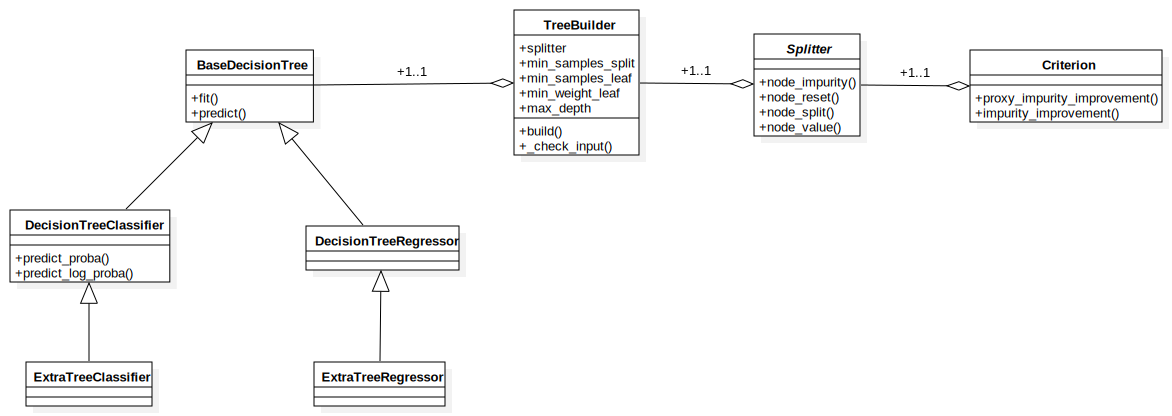

In [2]:
SVG("./res/uml/Model__tree_0.svg")

`Tree.py` 下定义了 `BaseDecisionTree` 基类，实现了完整的分类和回归功能，衍生出的子类主要用于封装初始化参数。两种子类的区别在于：`DecisionTree*` 类会遍历特征和值，从而找到最佳分割点，而 `ExtraTree*` 类会随机抽取特征和值，来寻找分割点。

下面是基类的训练方法 `fit` 流程：

1. 检查参数。
2. 设置评价函数。
3. 创建分割方法：根据数据是否稀疏阵，生成相应类。
4. 创建树：根据叶子数决定用深度优先还是评价优先。
5. 调用树的构建方法：生成决策树。

代码如下，细节已经折叠：

```python
  72 class BaseDecisionTree(six.with_metaclass(ABCMeta, BaseEstimator,
  73                                           _LearntSelectorMixin)):
  74     """Base class for decision trees.
  75 #+--  3 lines: Warning: This class should not be used directly.-------------------
  78     """
  79
  80     @abstractmethod
  81     def __init__(self,
  82 #+-- 30 lines: criterion,---------------------------------------------------------
 112
 113     def fit(self, X, y, sample_weight=None, check_input=True,
 114             X_idx_sorted=None):
 115         """Build a decision tree from the training set (X, y).
 116 #+-- 34 lines: Parameters---------------------------------------------------------
 150         """
 151
 152 #+--180 lines: random_state = check_random_state(self.random_state)---------------
 332
 333         # Build tree
 334         criterion = self.criterion
 335 #+--  6 lines: if not isinstance(criterion, Criterion):---------------------------
 341
 342         SPLITTERS = SPARSE_SPLITTERS if issparse(X) else DENSE_SPLITTERS
 343 #+--  9 lines: splitter = self.splitter-------------------------------------------
 352
 353         self.tree_ = Tree(self.n_features_, self.n_classes_, self.n_outputs_)
 354
 355         # Use BestFirst if max_leaf_nodes given; use DepthFirst otherwise
 356         if max_leaf_nodes < 0:
 357             builder = DepthFirstTreeBuilder(splitter, min_samples_split,
 358                                             min_samples_leaf,
 359                                             min_weight_leaf,
 360                                             max_depth)
 361         else:
 362             builder = BestFirstTreeBuilder(splitter, min_samples_split,
 363                                            min_samples_leaf,
 364                                            min_weight_leaf,
 365                                            max_depth,
 366                                            max_leaf_nodes)
 367
 368         builder.build(self.tree_, X, y, sample_weight, X_idx_sorted)
 369
 370 #+--  3 lines: if self.n_outputs_ == 1:-------------------------------------------
 373
 374         return self
```

预测方法 `predict` 代码非常简单，调用 `tree_.predict()` 方法取得预测值：如果是分类问题，输出预测值最大的类；如果是回归问题，直接输出。

```Python
 398     def predict(self, X, check_input=True):
 399         """Predict class or regression value for X.
 400 +-- 20 lines: For a classification model, the predicted class for each sample in X
 420         """
 421
 422         X = self._validate_X_predict(X, check_input)
 423         proba = self.tree_.predict(X)
 424         n_samples = X.shape[0]
 425
 426         # Classification
 427         if isinstance(self, ClassifierMixin):
 428             if self.n_outputs_ == 1:
 429                 return self.classes_.take(np.argmax(proba, axis=1), axis=0)        
 430
 431 +---  9 lines: else:--------------------------------------------------------------
 440
 441         # Regression
 442         else:
 443             if self.n_outputs_ == 1:
 444                 return proba[:, 0]
 445 +---  3 lines: else:--------------------------------------------------------------
 ```

sklearn 的决策树是 CART(Classification and Regression Trees) 算法，分类问题会转换成预测概率的回归问题，所以两类问题的处理方法是相同的，主要区别在评价函数。

### 2 模块简介

##### 2.0 评价函数
`_criterion.*` 是评价函数相关的文件，用 Cython 实现，*.pxd 和 *.pyx 文件分别对等 C 语言中的 *.h 和 *.c 文件。

下面是类的关系图：

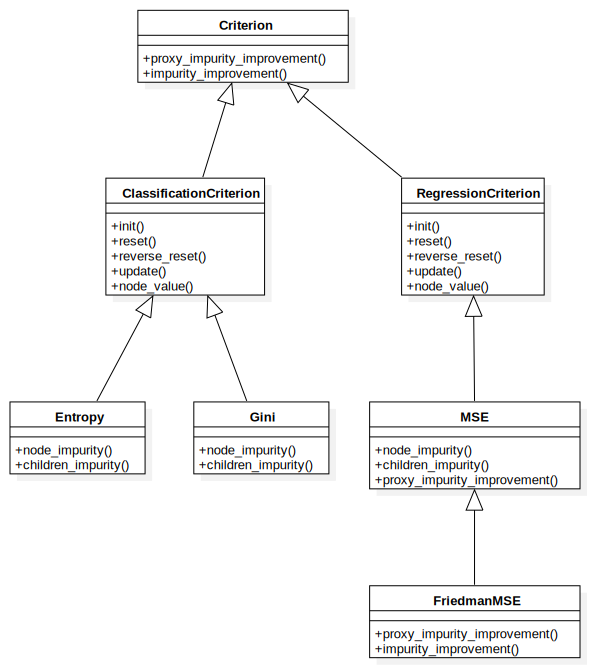

In [3]:
SVG("./res/uml/Model___criterion_1.svg")

+ 对于分类问题，sklearn 提供了 Gini 和 Entropy 两种评价函数；
  - 默认会用 Gini 。
  - [Decision Trees: “Gini” vs. “Entropy” criteria](https://www.garysieling.com/blog/sklearn-gini-vs-entropy-criteria)

+ 对于回归问题，则提供了 MSE（均方差）和 FriedmanMSE。
  - 默认会用 MSE 。
  - FriedmanMSE 用于 gradient boosting。
  
在实际使用中，我们应该都测试下同的评价函数。

##### 2.1 分割方法
`_splitter.*` 是分割方法相关的文件。

下面是类的关系图：

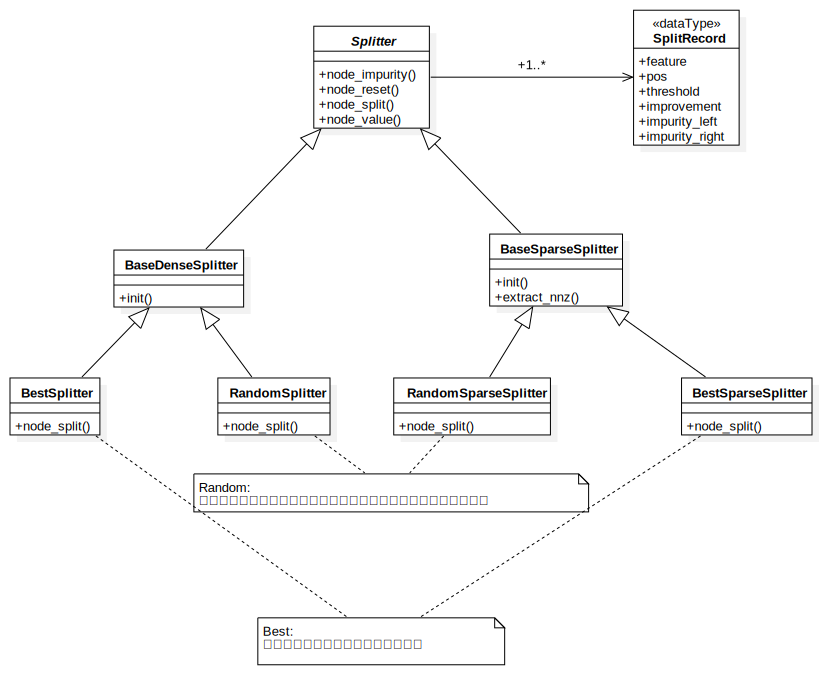

In [4]:
SVG("./res/uml/Model___splitter_2.svg")

`Splitter` 基类依数据储存方式（实阵或稀疏阵）衍生为 `BaseDenseSplitte` 和 `BaseSparseSplitter`。在这之下根据阈值的寻优方法再细分两类：`Best*Splitter` 会遍历特征的可能值，而 `Random*Splitter` 则是随机抽取。

##### 2.2 树的组建方法
`_tree.*` 是树组建方法相关的文件。

下面是类的关系图：

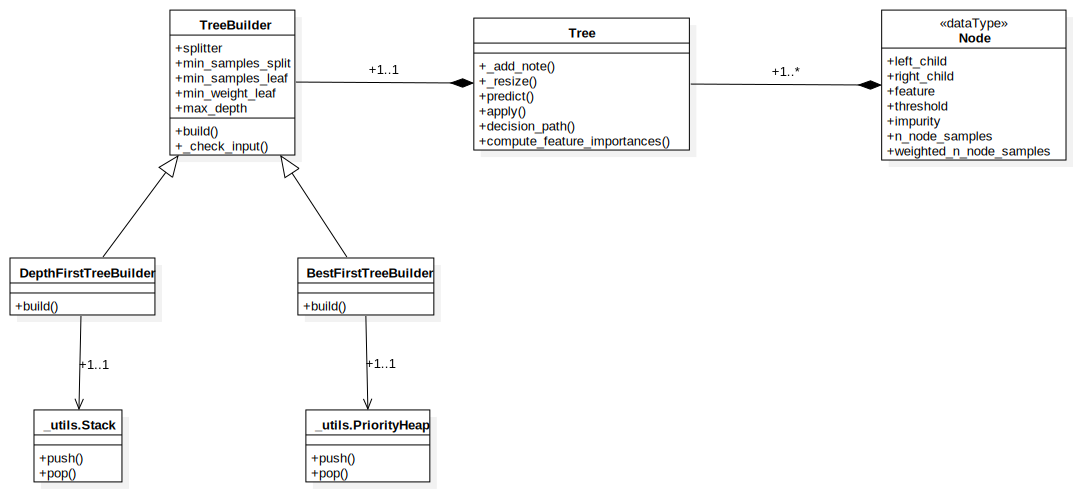

In [5]:
SVG("./res/uml/Model___tree_3.svg")

sklearn 提供了两种树的组建方法：一种是用栈实现的深度优先方法，它会先左后右地生成整颗决策树；另一种是用最大堆实现的最优优先方法，它每次在纯净度提升最大的节点进行分割生长。

### 3 结语
本文简单介绍了 sklearn 中决策树的实现框架，后面会对各子模块作进一步的详述。